In [45]:
# IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from AI.algorithms_from_scratch.data_plotting import Plots



In [46]:
# GENERATE DATA
X, y = datasets.make_moons(n_samples=1_000, noise=0.15, random_state=42)


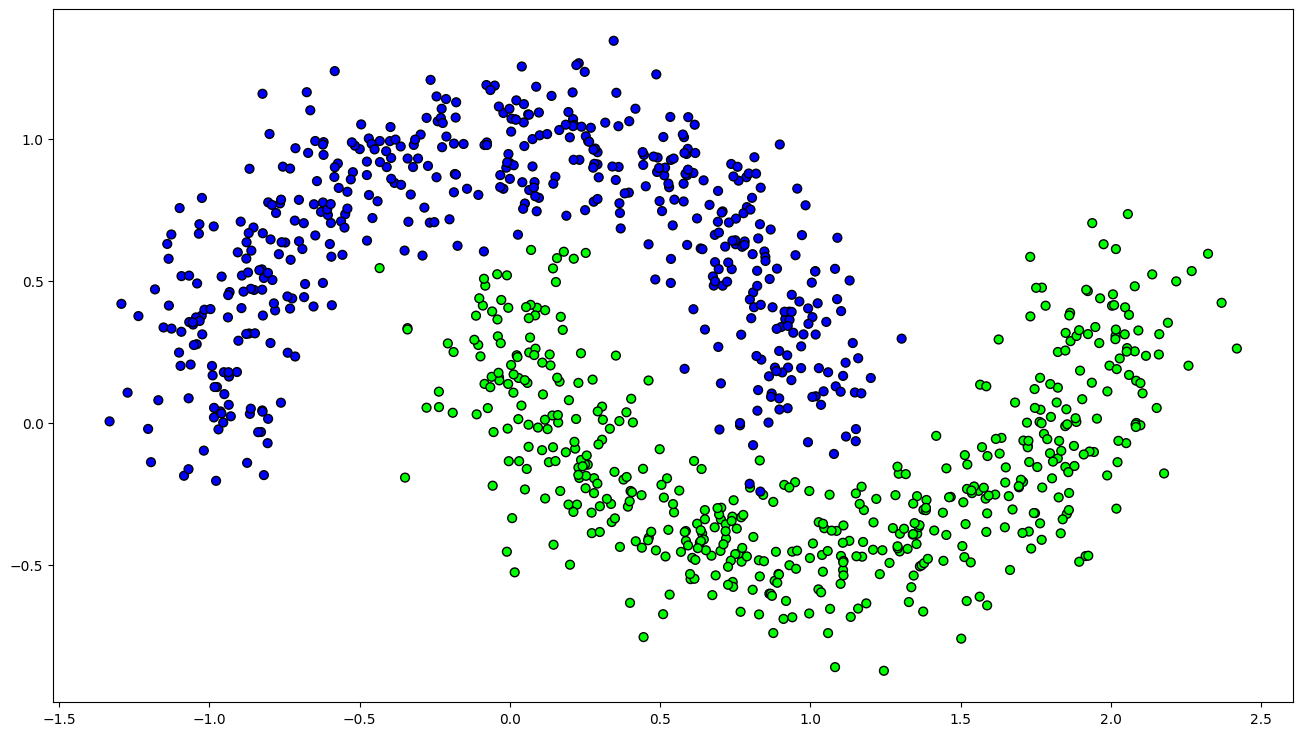

In [47]:
# PLOT DATA
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="brg", edgecolors="k")


In [48]:
# SCALE DATA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [49]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [50]:
# CREATE MODEL

from sklearn.base import BaseEstimator
from sklearn.preprocessing import PolynomialFeatures
from AI.algorithms_from_scratch.my_base_models import MySupportVectorClassiferBase

class MyPolynomialSoftMargSVC(BaseEstimator, MySupportVectorClassiferBase):
    def __init__(self, C=1, eta0=1, eta_d=1000, n_epochs=1000, degree=2, include_bias=False):
        """
        This class uses soft margin SVM to classify the data with polynomial features.
        It uses hinge loss as a loss function. The features are transformed using
        PolynomialFeatures from sklearn to allow for non-linear decision boundaries.
        
        :param C: Regularization parameter 
        :param eta0: Learning rate parameter
        :param eta_d: Learning rate decay parameter 
        :param n_epochs: Number of epochs
        :param degree: Degree of the polynomial features
        :param include_bias: Whether to include a bias column in the polynomial features
        """

        super().__init__()
        self.C = C
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.degree = degree
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=self.include_bias)
        self.Js = []  # Container for losses
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None

    def fit(self, X, y):
        """
        This function fits the model to the training data after transforming
        the features into polynomial features.
        
        :param X: Feature dataset
        :param y: Labels
        :returns: self
        """
        # Transform the features into polynomial features
        X_poly = self.poly.fit_transform(X)

        # Random initialization of weights and bias
        coef_ = np.random.randn(X_poly.shape[1], 1)  # number of feature weights
        intercept_ = 0

        X_t, t = self.transform_datapoints_to_positive_and_negative(X_poly, y)

        # Training
        for epoch in range(self.n_epochs):
            X_t_sv, t_sv, _ = self.select_margin_violators(X_t, t, intercept_, coef_)

            # Compute hinge loss (Just for visualization)
            J = 1 / 2 * (coef_ * coef_).sum() + self.C * ((1 - X_t_sv.dot(coef_)).sum() - intercept_ * t_sv.sum())
            self.Js.append(J)

            # Compute gradients
            w_gradient_vector = coef_ - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -(self.C) * t_sv.sum()

            # Update weights and bias
            eta = self.eta(epoch)
            coef_ = coef_ - eta * w_gradient_vector
            intercept_ = intercept_ - eta * b_derivative

        _, _, support_vectors_idx = self.select_margin_violators(X_t, t, intercept_, coef_)
        self.intercept_ = np.array([intercept_])
        self.coef_ = np.array([coef_])
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        # Transform the features into polynomial features
        X_poly = self.poly.transform(X)
        return X_poly.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0


In [51]:
# TRAIN MODEL

C = 1
eta_0 = 1
eta_d = 1000
n_epochs = 1000
degree = 3
include_bias = True
svc1 = MyPolynomialSoftMargSVC(C=C, eta0=eta_0, eta_d=eta_d, n_epochs=n_epochs, degree=degree, include_bias=include_bias)
svc1.fit(X_train, y_train)

MyPolynomialSoftMargSVC(degree=3, include_bias=True)

In [52]:
# CROSS VALIDATION
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc1, X_test, y_test, cv=10, scoring="accuracy")
scores

array([1.  , 1.  , 1.  , 0.95, 1.  , 1.  , 1.  , 1.  , 0.9 , 1.  ])

In [53]:
print(svc1.show_parameters())

coef_:
[[[ 0.0613678 ]
  [-3.57723654]
  [-0.58882015]
  [ 0.14982086]
  [ 0.3335248 ]
  [ 0.21048211]
  [ 2.65519122]
  [-0.24438843]
  [ 0.87134787]
  [-1.67108863]]]

intercept_:
[-0.07142362]

support_vectors_:
[[ 3.79979265e-01 -7.37375356e-01]
 [ 1.31157923e-01 -7.41210632e-01]
 [-8.96803946e-01  6.65589534e-01]
 [-5.35450312e-01  8.08491556e-01]
 [-1.00328321e-01 -4.77233218e-01]
 [ 1.59685304e-01 -7.96168302e-01]
 [ 4.39032794e-02  6.42538574e-01]
 [-3.24142138e-01  6.43870216e-01]
 [-6.63997542e-01  5.06699798e-01]
 [ 9.53559748e-02 -1.10167426e-01]
 [-6.64411672e-01  6.93908434e-01]
 [ 6.60931042e-01 -6.92838660e-01]
 [-9.64681412e-01  6.99655847e-01]
 [-2.52865347e-01 -1.83845365e-01]
 [ 2.32877652e-01 -2.09608909e-01]
 [-6.59148480e-01  4.59466976e-01]
 [-5.77231908e-01  5.30209032e-01]
 [-3.61820131e-01  6.91884187e-01]
 [-7.64211508e-01  7.32426032e-01]
 [ 1.72449305e-01  1.58906297e-01]
 [ 7.43302937e-01 -6.05713740e-01]
 [-4.85758291e-01  7.04035677e-01]
 [-3.91719793e-

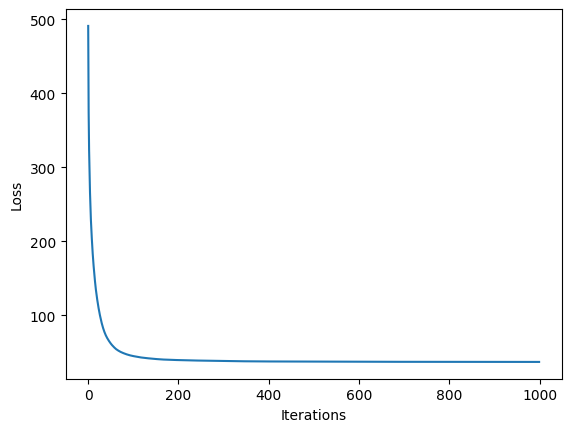

In [54]:
svc1.show_loss_curve()

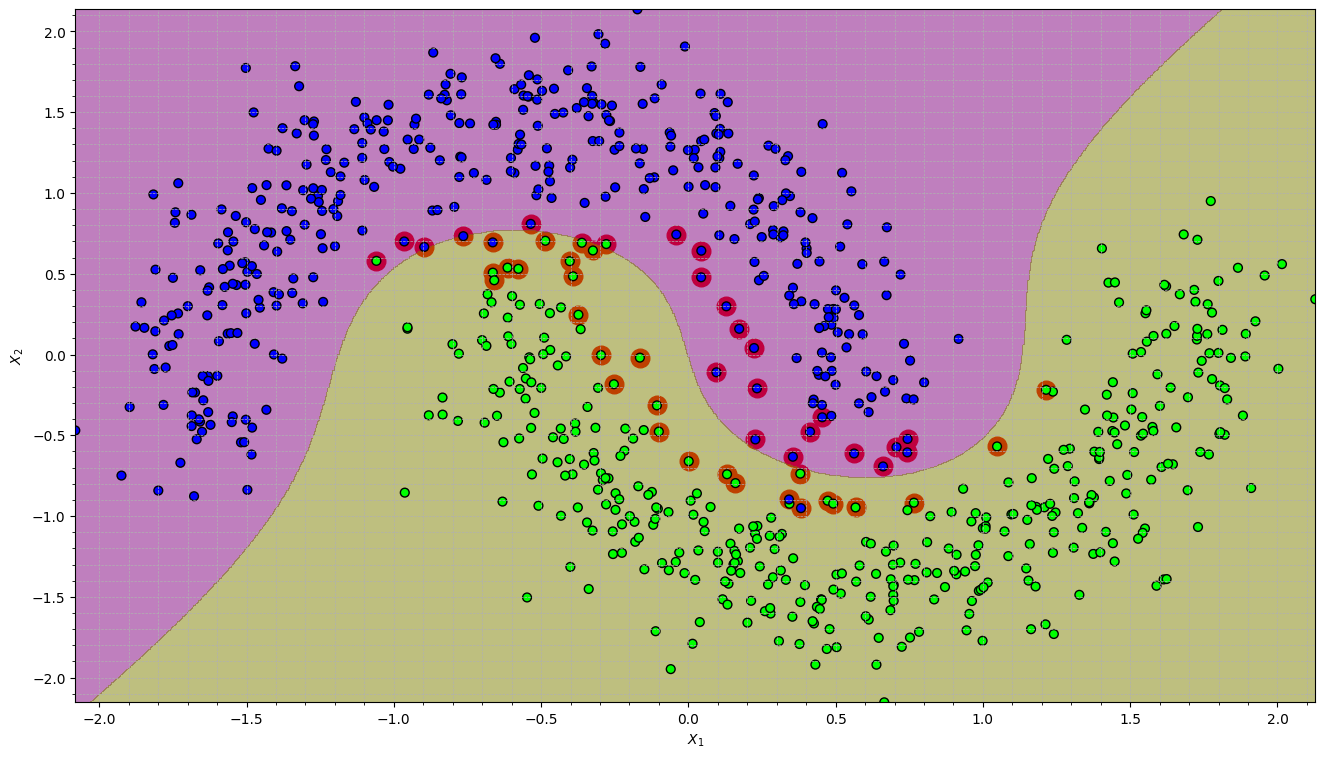

In [55]:
# PLOT DECISION BOUNDARY
plot = Plots()
plot.plot_decision_boundary(svc1, X_train, y_train, svm_poly=True, bound_smoot=1000)